In [64]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from scipy.stats import norm
from scipy.stats import skew
from scipy.stats.stats import pearsonr

from sklearn.linear_model import Ridge, RidgeCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.model_selection import KFold, StratifiedKFold,RepeatedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

from numpy import mean
from numpy import std
from numpy import absolute

from lofo import LOFOImportance, FLOFOImportance, Dataset, plot_importance
import optuna

import shap
from tqdm.autonotebook import tqdm

In [65]:
def plot_corr_matrix(df, nr_c, targ) :
    
    corr = df.corr()
    corr_abs = corr.abs()
    cols = corr_abs.nlargest(nr_c, targ)[targ].index
    cm = np.corrcoef(df[cols].values.T)

    plt.figure(figsize=(nr_c/1.5, nr_c/1.5))
    sns.set(font_scale=1.25)
    sns.heatmap(cm, linewidths=1.5, annot=True, square=True, 
                fmt='.2f', annot_kws={'size': 10}, 
                yticklabels=cols.values, xticklabels=cols.values
               )
    plt.show()

# Exploratory Data Analysis

In [66]:
df_train = pd.read_csv("HousePrices/train.csv")
df_test = pd.read_csv("HousePrices/test.csv")

In [67]:
print(df_train.shape)
print("*"*50)
print(df_test.shape)

(1460, 81)
**************************************************
(1459, 80)


In [68]:
print(df_train.info())
print("*"*50)
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [69]:
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [70]:
df_train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [71]:
df_test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [72]:
df_test.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,1459.000000,1459.000000,1232.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1444.000000,1458.000000,...,1458.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000
mean,2190.000000,57.378341,68.580357,9819.161069,6.078821,5.553804,1971.357779,1983.662783,100.709141,439.203704,...,472.768861,93.174777,48.313914,24.243317,1.794380,17.064428,1.744345,58.167923,6.104181,2007.769705
std,421.321334,42.746880,22.376841,4955.517327,1.436812,1.113740,30.390071,21.130467,177.625900,455.268042,...,217.048611,127.744882,68.883364,67.227765,20.207842,56.609763,30.491646,630.806978,2.722432,1.301740
min,1461.000000,20.000000,21.000000,1470.000000,1.000000,1.000000,1879.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,1825.500000,20.000000,58.000000,7391.000000,5.000000,5.000000,1953.000000,1963.000000,0.000000,0.000000,...,318.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000
50%,2190.000000,50.000000,67.000000,9399.000000,6.000000,5.000000,1973.000000,1992.000000,0.000000,350.500000,...,480.000000,0.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,2554.500000,70.000000,80.000000,11517.500000,7.000000,6.000000,2001.000000,2004.000000,164.000000,753.500000,...,576.000000,168.000000,72.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,2919.000000,190.000000,200.000000,56600.000000,10.000000,9.000000,2010.000000,2010.000000,1290.000000,4010.000000,...,1488.000000,1424.000000,742.000000,1012.000000,360.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000


`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


Skewness: 1.882876
Kurtosis: 6.536282


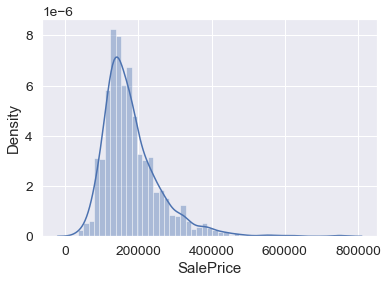

In [73]:
sns.distplot(df_train['SalePrice']);
#skewness and kurtosis
print("Skewness: %f" % df_train['SalePrice'].skew())
print("Kurtosis: %f" % df_train['SalePrice'].kurt())

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


Skewness: 0.121335
Kurtosis: 0.809532


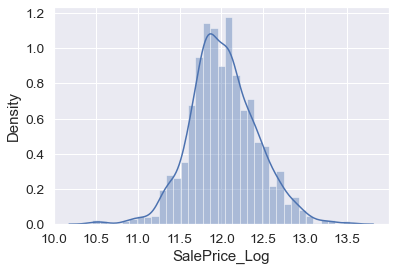

In [74]:
df_train['SalePrice_Log'] = np.log(df_train['SalePrice'])

sns.distplot(df_train['SalePrice_Log']);
# skewness and kurtosis
print("Skewness: %f" % df_train['SalePrice_Log'].skew())
print("Kurtosis: %f" % df_train['SalePrice_Log'].kurt())
# dropping old column
df_train.drop('SalePrice', axis= 1, inplace=True)

Numerical and Categorical features

In [75]:
numerical_feats=df_train.dtypes[df_train.dtypes!="object"].index
print("Number of Numerical features: ",len(numerical_feats))

categorical_feats=df_train.dtypes[df_train.dtypes=="object"].index
print("Number of Numerical features: ",len(categorical_feats))

Number of Numerical features:  38
Number of Numerical features:  43


In [76]:
print(df_train[numerical_feats].columns)


Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice_Log'],
      dtype='object')


In [77]:
print(df_train[categorical_feats].columns)

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')


List of features with missing values

In [78]:
total=df_train.isnull().sum().sort_values(ascending=False)
percent=(df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data=pd.concat([total,percent],axis=1,keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageYrBlt,81,0.055479
GarageCond,81,0.055479
GarageType,81,0.055479
GarageFinish,81,0.055479


In [79]:
total=df_test.isnull().sum().sort_values(ascending=False)
percent=(df_test.isnull().sum()/df_test.isnull().count()).sort_values(ascending=False)
missing_data=pd.concat([total,percent],axis=1,keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1456,0.997944
MiscFeature,1408,0.965045
Alley,1352,0.926662
Fence,1169,0.801234
FireplaceQu,730,0.500343
LotFrontage,227,0.155586
GarageYrBlt,78,0.053461
GarageQual,78,0.053461
GarageFinish,78,0.053461
GarageCond,78,0.053461


Filling missing values
********
For a few columns there is lots of NaN entries.
However, reading the data description we find this is not missing data:
For PoolQC, NaN is not missing data but means no pool, likewise for Fence, FireplaceQu etc.

In [80]:
# columns where NaN values have meaning e.g. no pool etc.
cols_fillna = ['PoolQC','MiscFeature','Alley','Fence','MasVnrType','FireplaceQu',
               'GarageQual','GarageCond','GarageFinish','GarageType', 'Electrical',
               'KitchenQual', 'SaleType', 'Functional', 'Exterior2nd', 'Exterior1st',
               'BsmtExposure','BsmtCond','BsmtQual','BsmtFinType1','BsmtFinType2',
               'MSZoning', 'Utilities']

for col in cols_fillna:
    df_train[col].fillna("None",inplace=True)
    df_test[col].fillna("None",inplace=True)
    

In [81]:
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
LotFrontage,259,0.177397
GarageYrBlt,81,0.055479
MasVnrArea,8,0.005479
Id,0,0.000000
KitchenAbvGr,0,0.000000
GarageType,0,0.000000
FireplaceQu,0,0.000000
Fireplaces,0,0.000000
Functional,0,0.000000
TotRmsAbvGrd,0,0.000000


In [82]:
total=df_test.isnull().sum().sort_values(ascending=False)
percent=(df_test.isnull().sum()/df_test.isnull().count()).sort_values(ascending=False)
missing_data=pd.concat([total,percent],axis=1,keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
LotFrontage,227,0.155586
GarageYrBlt,78,0.053461
MasVnrArea,15,0.010281
BsmtFullBath,2,0.001371
BsmtHalfBath,2,0.001371
GarageCars,1,0.000685
TotalBsmtSF,1,0.000685
BsmtUnfSF,1,0.000685
BsmtFinSF2,1,0.000685
BsmtFinSF1,1,0.000685


In [83]:
# fillna with mean for the remaining columns: LotFrontage, GarageYrBlt, MasVnrArea
df_train.fillna(df_train.mean(),inplace=True)
df_test.fillna(df_test.mean(),inplace=True)

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


In [84]:
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(5)

,Total,Percent
Id,0,0.0
CentralAir,0,0.0
GarageYrBlt,0,0.0
GarageType,0,0.0
FireplaceQu,0,0.0


In [85]:
total = df_test.isnull().sum().sort_values(ascending=False)
percent = (df_test.isnull().sum()/df_test.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(5)

,Total,Percent
Id,0,0.0
MSSubClass,0,0.0
GarageType,0,0.0
FireplaceQu,0,0.0
Fireplaces,0,0.0


In [86]:
df_train.isnull().sum().sum()

0

In [87]:
df_test.isnull().sum().sum()

0

log transform
*****
Like the target variable, also some of the feature values are not normally distributed and it is therefore better to use log values in df_train and df_test. Checking for skewness and kurtosis

In [88]:
for col in numerical_feats:
    print('{:15}'.format(col), 
          'Skewness: {:05.2f}'.format(df_train[col].skew()) , 
          '   ' ,
          'Kurtosis: {:06.2f}'.format(df_train[col].kurt())  
         )

Id              Skewness: 00.00     Kurtosis: -01.20
MSSubClass      Skewness: 01.41     Kurtosis: 001.58
LotFrontage     Skewness: 02.38     Kurtosis: 021.85
LotArea         Skewness: 12.21     Kurtosis: 203.24
OverallQual     Skewness: 00.22     Kurtosis: 000.10
OverallCond     Skewness: 00.69     Kurtosis: 001.11
YearBuilt       Skewness: -0.61     Kurtosis: -00.44
YearRemodAdd    Skewness: -0.50     Kurtosis: -01.27
MasVnrArea      Skewness: 02.68     Kurtosis: 010.15
BsmtFinSF1      Skewness: 01.69     Kurtosis: 011.12
BsmtFinSF2      Skewness: 04.26     Kurtosis: 020.11
BsmtUnfSF       Skewness: 00.92     Kurtosis: 000.47
TotalBsmtSF     Skewness: 01.52     Kurtosis: 013.25
1stFlrSF        Skewness: 01.38     Kurtosis: 005.75
2ndFlrSF        Skewness: 00.81     Kurtosis: -00.55
LowQualFinSF    Skewness: 09.01     Kurtosis: 083.23
GrLivArea       Skewness: 01.37     Kurtosis: 004.90
BsmtFullBath    Skewness: 00.60     Kurtosis: -00.84
BsmtHalfBath    Skewness: 04.10     Kurtosis: 

Skewness: 1.366560
Kurtosis: 4.895121


`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


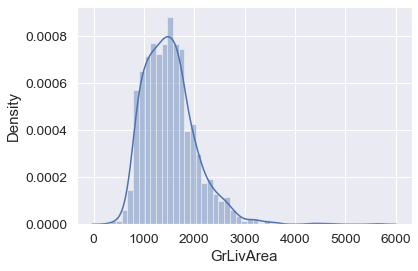

In [89]:
sns.distplot(df_train['GrLivArea']);
#skewness and kurtosis
print("Skewness: %f" % df_train['GrLivArea'].skew())
print("Kurtosis: %f" % df_train['GrLivArea'].kurt())

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


Skewness: 12.207688
Kurtosis: 203.243271


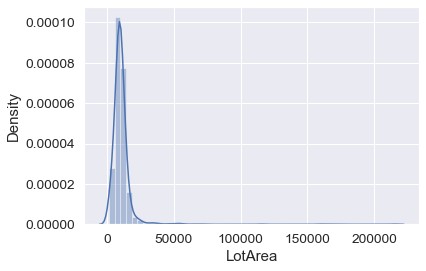

In [90]:
sns.distplot(df_train['LotArea']);
#skewness and kurtosis
print("Skewness: %f" % df_train['LotArea'].skew())
print("Kurtosis: %f" % df_train['LotArea'].kurt())

In [91]:
for df in [df_train, df_test]:
    df['GrLivArea_Log'] = np.log(df['GrLivArea'])
    df.drop('GrLivArea', inplace= True, axis = 1)
    df['LotArea_Log'] = np.log(df['LotArea'])
    df.drop('LotArea', inplace= True, axis = 1)
    
    
    
numerical_feats = df_train.dtypes[df_train.dtypes != "object"].index

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


Skewness: -0.006995
Kurtosis: 0.282603


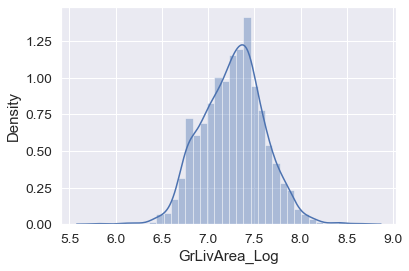

In [92]:
sns.distplot(df_train['GrLivArea_Log']);
#skewness and kurtosis
print("Skewness: %f" % df_train['GrLivArea_Log'].skew())
print("Kurtosis: %f" % df_train['GrLivArea_Log'].kurt())

Plots of relation to target for all numerical features

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


Skewness: -0.137994
Kurtosis: 4.713358


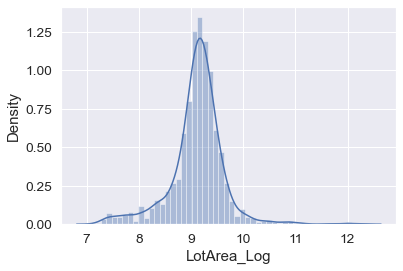

In [93]:
sns.distplot(df_train['LotArea_Log']);
#skewness and kurtosis
print("Skewness: %f" % df_train['LotArea_Log'].skew())
print("Kurtosis: %f" % df_train['LotArea_Log'].kurt())

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argumen

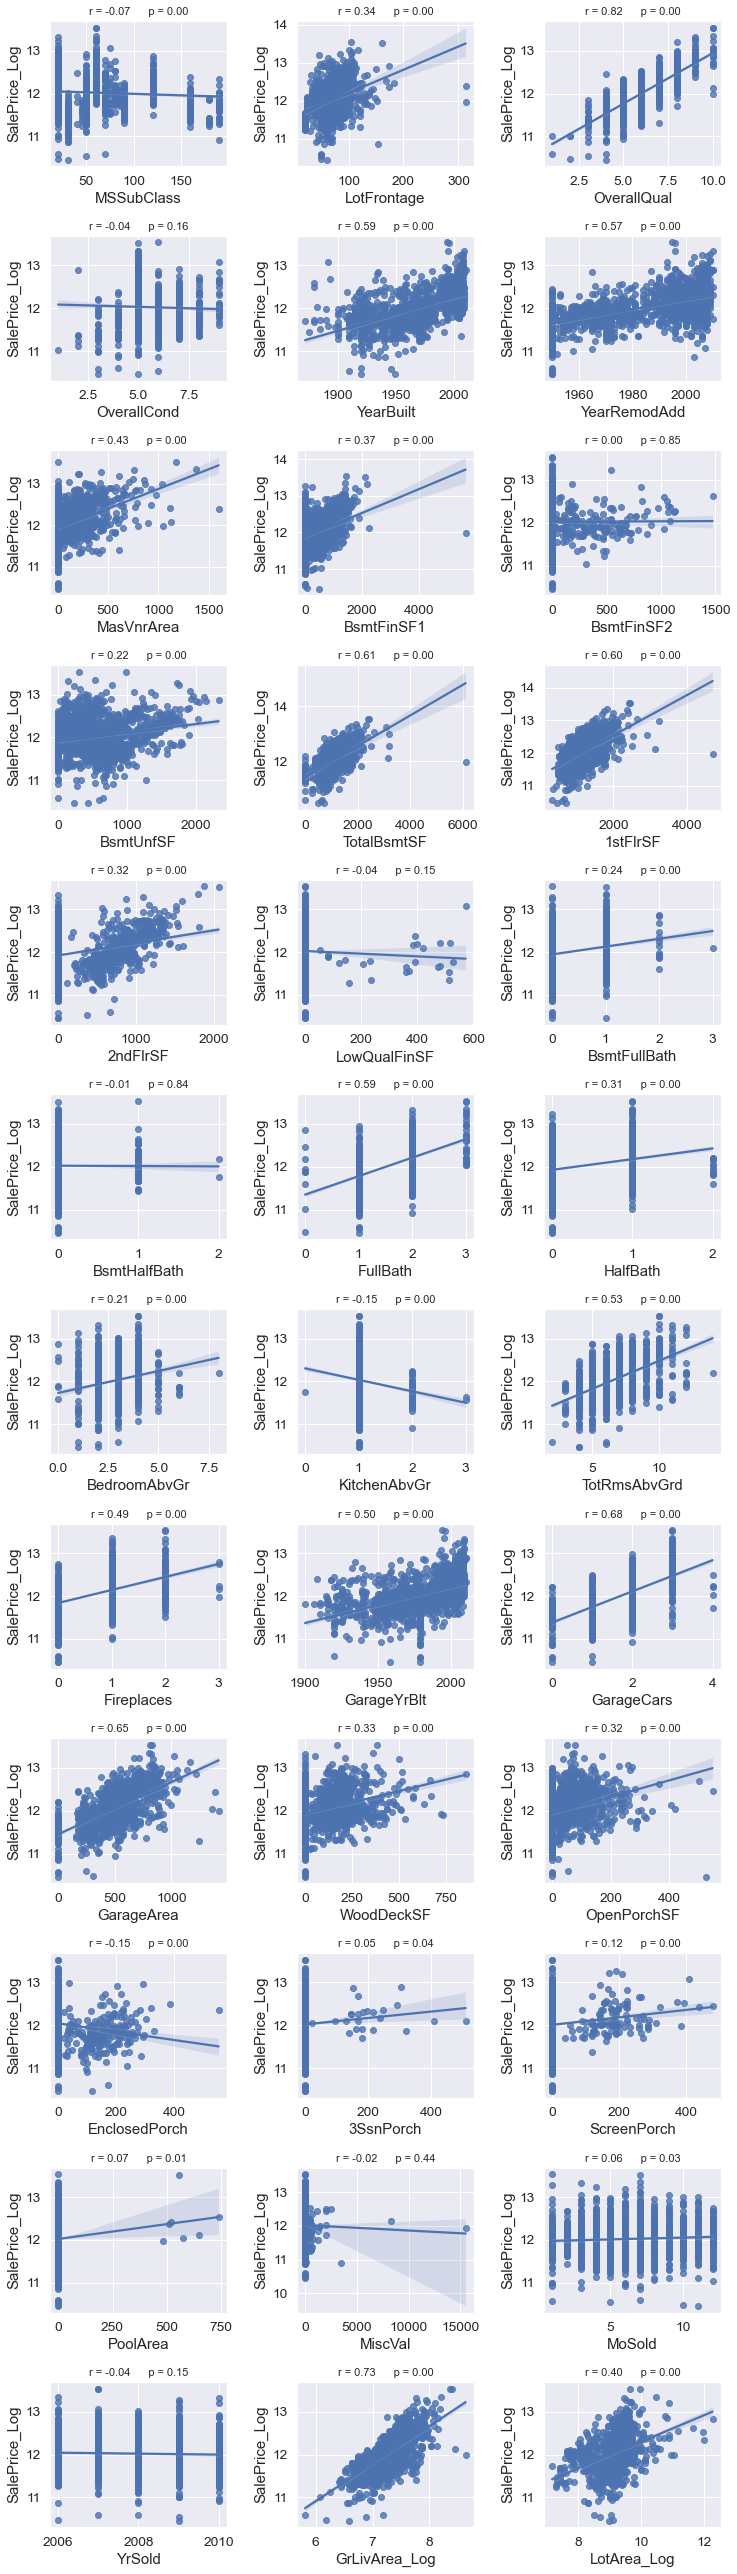

In [94]:
nr_rows=12
nr_cols=3
target = 'SalePrice_Log'
fig,axs=plt.subplots(nr_rows,nr_cols,figsize=(nr_cols*3.5,nr_rows*3))

li_num=feats=list(numerical_feats)
li_not_plot=['Id','SalePrice','SalePrice_Log']

li_plot_num_feats=[c for c in list(numerical_feats) if c not in  li_not_plot]

for r in range(0,nr_rows):
    for c in range(0,nr_cols):
        i=r*nr_cols+c
        if i<len(li_plot_num_feats):
            sns.regplot(df_train[li_plot_num_feats[i]], df_train[target], ax = axs[r][c])
            stp = stats.pearsonr(df_train[li_plot_num_feats[i]], df_train[target])
            #axs[r][c].text(0.4,0.9,"title",fontsize=7)
            str_title = "r = " + "{0:.2f}".format(stp[0]) + "      " "p = " + "{0:.2f}".format(stp[1])
            axs[r][c].set_title(str_title,fontsize=11)
            
            
plt.tight_layout()    
plt.show()             

# Outliers

In [95]:
df_train = df_train.drop(
    df_train[(df_train['OverallQual']==10) & (df_train['SalePrice_Log']<12.3)].index)

In [96]:
df_train = df_train.drop(
    df_train[(df_train['GrLivArea_Log']>8.3) & (df_train['SalePrice_Log']<12.5)].index)

In [97]:
corr = df_train.corr()
corr_abs = corr.abs()

# only columns with correlation above this threshold value  
min_val_corr = 0.4    
    
nr_num_cols = len(numerical_feats)
ser_corr = corr_abs.nlargest(nr_num_cols, target)[target]

cols_abv_corr_limit = list(ser_corr[ser_corr.values > min_val_corr].index)
cols_bel_corr_limit = list(ser_corr[ser_corr.values <= min_val_corr].index)

List of numerical features and their correlation coefficient to target

In [98]:
print(ser_corr)

SalePrice_Log    1.000000
OverallQual      0.821404
GrLivArea_Log    0.737427
GarageCars       0.681033
GarageArea       0.656128
TotalBsmtSF      0.647563
1stFlrSF         0.620500
FullBath         0.595899
YearBuilt        0.587043
YearRemodAdd     0.565992
TotRmsAbvGrd     0.537702
GarageYrBlt      0.500842
Fireplaces       0.491998
MasVnrArea       0.433353
LotArea_Log      0.402814
BsmtFinSF1       0.392283
LotFrontage      0.352432
WoodDeckSF       0.334250
OpenPorchSF      0.325215
2ndFlrSF         0.319953
HalfBath         0.314186
BsmtFullBath     0.237099
BsmtUnfSF        0.221892
BedroomAbvGr     0.209036
EnclosedPorch    0.149029
KitchenAbvGr     0.147534
ScreenPorch      0.121245
PoolArea         0.074338
MSSubClass       0.073969
MoSold           0.057064
3SsnPorch        0.054914
LowQualFinSF     0.037951
YrSold           0.037151
OverallCond      0.036821
MiscVal          0.020012
Id               0.017774
BsmtHalfBath     0.005124
BsmtFinSF2       0.004863
Name: SalePr

# Numerical and Categorical Features

In [99]:
print("List of numerical features with r above min_val_corr :")
print(cols_abv_corr_limit)

List of numerical features with r above min_val_corr :
['SalePrice_Log', 'OverallQual', 'GrLivArea_Log', 'GarageCars', 'GarageArea', 'TotalBsmtSF', '1stFlrSF', 'FullBath', 'YearBuilt', 'YearRemodAdd', 'TotRmsAbvGrd', 'GarageYrBlt', 'Fireplaces', 'MasVnrArea', 'LotArea_Log']


In [100]:
print("List of numerical features with r below min_val_corr :")
print(cols_bel_corr_limit)

List of numerical features with r below min_val_corr :
['BsmtFinSF1', 'LotFrontage', 'WoodDeckSF', 'OpenPorchSF', '2ndFlrSF', 'HalfBath', 'BsmtFullBath', 'BsmtUnfSF', 'BedroomAbvGr', 'EnclosedPorch', 'KitchenAbvGr', 'ScreenPorch', 'PoolArea', 'MSSubClass', 'MoSold', '3SsnPorch', 'LowQualFinSF', 'YrSold', 'OverallCond', 'MiscVal', 'Id', 'BsmtHalfBath', 'BsmtFinSF2']


List of categorical features and their unique values

In [101]:
for catg in list(categorical_feats):
    print(df_train[catg].value_counts())
    print('#'*50)

RL         1149
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64
##################################################
Pave    1452
Grvl       6
Name: Street, dtype: int64
##################################################
None    1367
Grvl      50
Pave      41
Name: Alley, dtype: int64
##################################################
Reg    925
IR1    483
IR2     41
IR3      9
Name: LotShape, dtype: int64
##################################################
Lvl    1311
Bnk      61
HLS      50
Low      36
Name: LandContour, dtype: int64
##################################################
AllPub    1457
NoSeWa       1
Name: Utilities, dtype: int64
##################################################
Inside     1051
Corner      262
CulDSac      94
FR2          47
FR3           4
Name: LotConfig, dtype: int64
##################################################
Gtl    1380
Mod      65
Sev      13
Name: LandSlope, dtype: int64
###########################

Relation to SalePrice for all categorical features

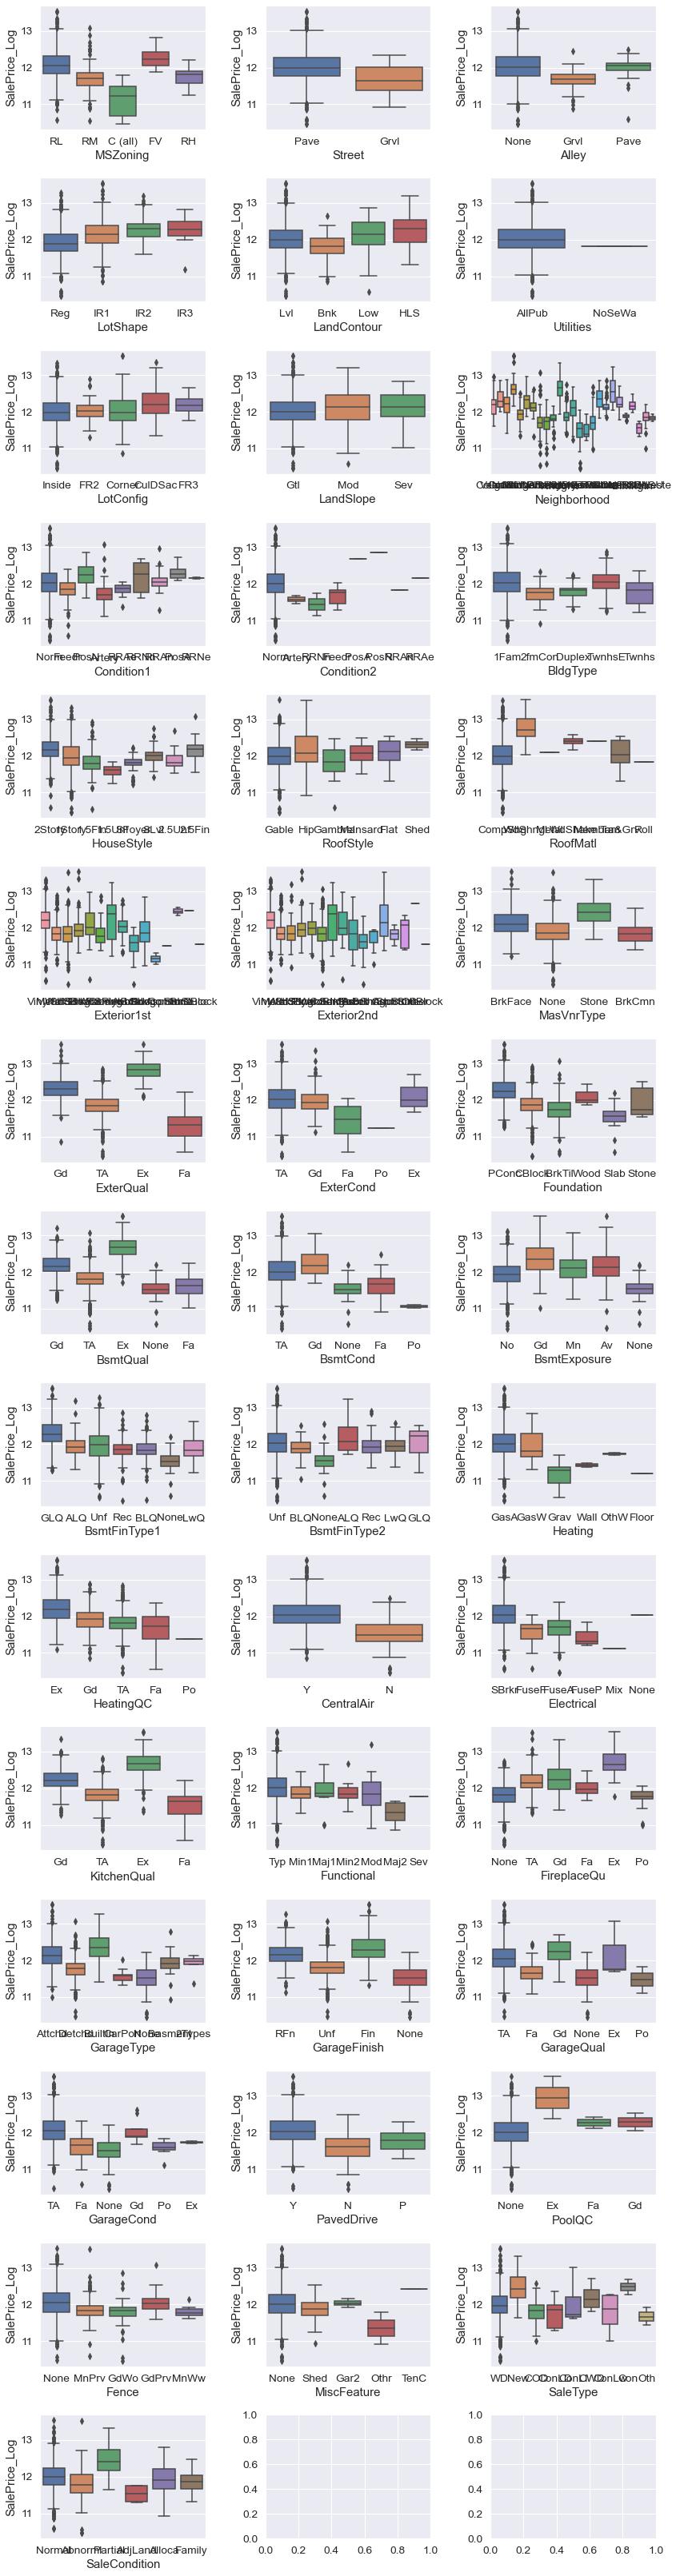

In [102]:
li_cat_feats = list(categorical_feats)
nr_rows = 15
nr_cols = 3

fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*4,nr_rows*3))

for r in range(0,nr_rows):
    for c in range(0,nr_cols):  
        i = r*nr_cols+c
        if i < len(li_cat_feats):
            sns.boxplot(x=li_cat_feats[i], y=target, data=df_train, ax = axs[r][c])
    
plt.tight_layout()    
plt.show() 

In [103]:
catg_strong_corr = [ 'MSZoning', 'Neighborhood', 'Condition2', 'MasVnrType', 'ExterQual', 
                     'BsmtQual','CentralAir', 'Electrical', 'KitchenQual', 'SaleType']

catg_weak_corr = ['Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 
                  'LandSlope', 'Condition1',  'BldgType', 'HouseStyle', 'RoofStyle', 
                  'RoofMatl', 'Exterior1st', 'Exterior2nd', 'ExterCond', 'Foundation', 
                  'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 
                  'HeatingQC', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 
                  'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 
                  'SaleCondition' ]

Features with largest correlation to SalePrice_Log

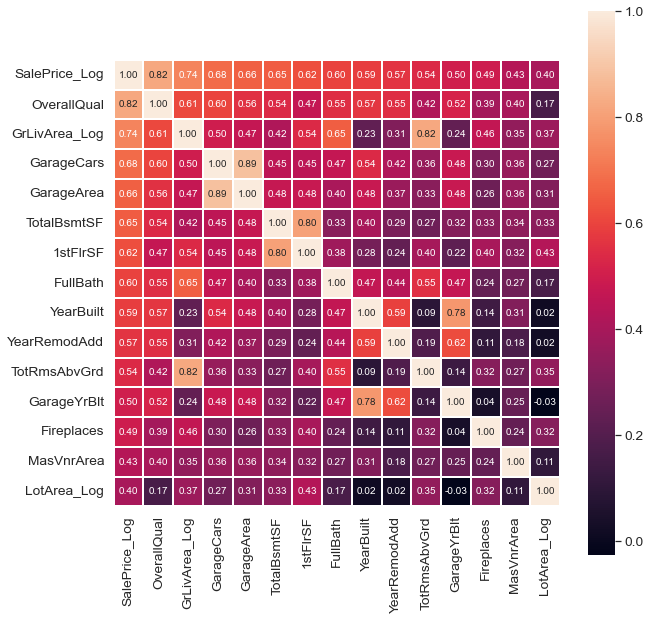

In [104]:
nr_feats = len(cols_abv_corr_limit)
plot_corr_matrix(df_train, nr_feats, target)


# Data wrangling

Drop all columns with only small correlation to SalePrice

Transform Categorical to numerical

Handling columns with missing data

Log values

Drop all columns with strong correlation to similar features

In [105]:
#Dropping all columns with weak correlation to SalePrice
id_test=df_test['Id']
to_drop_num=cols_bel_corr_limit
to_drop_catg=catg_weak_corr

cols_to_drop=['Id']+to_drop_num+to_drop_catg

for df in [df_train,df_test]:
    df.drop(cols_to_drop,inplace=True,axis=1)

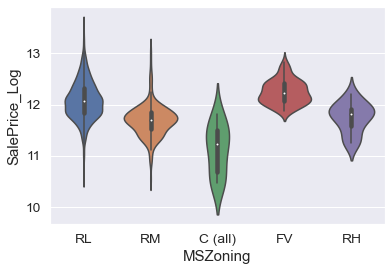

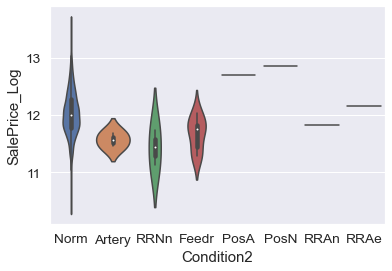

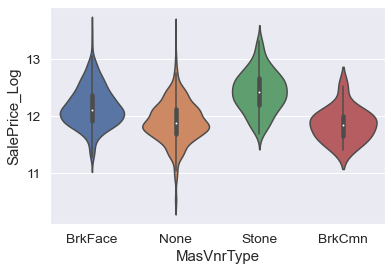

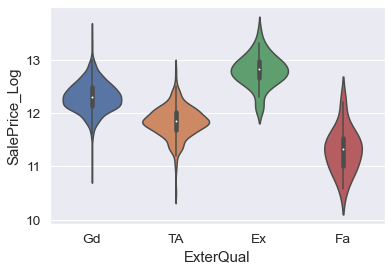

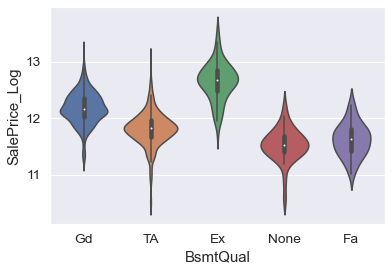

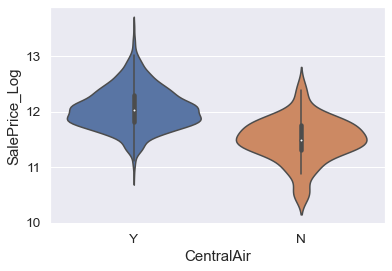

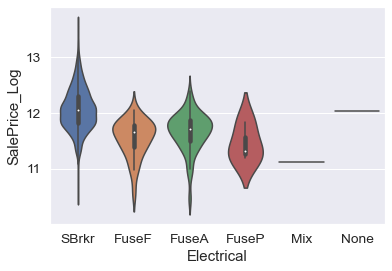

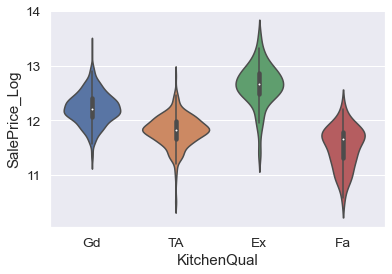

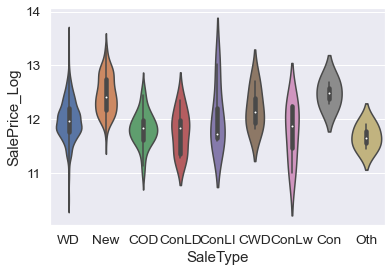

In [106]:
#Convert categorical columns to numerical
catg_list = catg_strong_corr.copy()
catg_list.remove('Neighborhood')

for catg in catg_list :
    #sns.catplot(x=catg, y=target, data=df_train, kind='boxen')
    sns.violinplot(x=catg, y=target, data=df_train)
    plt.show()

In [107]:
for catg in catg_list :
    g = df_train.groupby(catg)[target].mean()
    print(g)

MSZoning
C (all)    11.118259
FV         12.246616
RH         11.749840
RL         12.085939
RM         11.692893
Name: SalePrice_Log, dtype: float64
Condition2
Artery    11.570036
Feedr     11.670631
Norm      12.025925
PosA      12.691580
PosN      12.860999
RRAe      12.154779
RRAn      11.827043
RRNn      11.435329
Name: SalePrice_Log, dtype: float64
MasVnrType
BrkCmn     11.853239
BrkFace    12.163630
None       11.896884
Stone      12.431016
Name: SalePrice_Log, dtype: float64
ExterQual
Ex    12.792412
Fa    11.304541
Gd    12.311282
TA    11.837985
Name: SalePrice_Log, dtype: float64
BsmtQual
Ex      12.650235
Fa      11.617600
Gd      12.179882
None    11.529680
TA      11.810855
Name: SalePrice_Log, dtype: float64
CentralAir
N    11.491858
Y    12.061099
Name: SalePrice_Log, dtype: float64
Electrical
FuseA    11.660315
FuseF    11.539624
FuseP    11.446808
Mix      11.112448
None     12.028739
SBrkr    12.061474
Name: SalePrice_Log, dtype: float64
KitchenQual
Ex    12.645425
F

In [108]:
len(df_train.columns)

25

In [109]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1458 entries, 0 to 1459
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSZoning       1458 non-null   object 
 1   Neighborhood   1458 non-null   object 
 2   Condition2     1458 non-null   object 
 3   OverallQual    1458 non-null   int64  
 4   YearBuilt      1458 non-null   int64  
 5   YearRemodAdd   1458 non-null   int64  
 6   MasVnrType     1458 non-null   object 
 7   MasVnrArea     1458 non-null   float64
 8   ExterQual      1458 non-null   object 
 9   BsmtQual       1458 non-null   object 
 10  TotalBsmtSF    1458 non-null   int64  
 11  CentralAir     1458 non-null   object 
 12  Electrical     1458 non-null   object 
 13  1stFlrSF       1458 non-null   int64  
 14  FullBath       1458 non-null   int64  
 15  KitchenQual    1458 non-null   object 
 16  TotRmsAbvGrd   1458 non-null   int64  
 17  Fireplaces     1458 non-null   int64  
 18  GarageYr

In [110]:
len(df_test.columns)

24

In [111]:
def process_data():
    
    df_train = pd.read_csv("HousePrices/train.csv")
    df_test = pd.read_csv("HousePrices/test.csv")
    
    df_train['SalePrice_Log'] = np.log(df_train['SalePrice'])
    df_train.drop('SalePrice', axis= 1, inplace=True)
    
    numerical_feats=df_train.dtypes[df_train.dtypes!="object"].index
    categorical_feats=df_train.dtypes[df_train.dtypes=="object"].index
    
    cols_fillna = ['PoolQC','MiscFeature','Alley','Fence','MasVnrType','FireplaceQu',
               'GarageQual','GarageCond','GarageFinish','GarageType', 'Electrical',
               'KitchenQual', 'SaleType', 'Functional', 'Exterior2nd', 'Exterior1st',
               'BsmtExposure','BsmtCond','BsmtQual','BsmtFinType1','BsmtFinType2',
               'MSZoning', 'Utilities']
    
    # replace 'NaN' with 'None' in these columns
    for col in cols_fillna:
        df_train[col].fillna("None",inplace=True)
        df_test[col].fillna("None",inplace=True)
        
    # fillna with mean for the remaining columns: LotFrontage, GarageYrBlt, MasVnrArea
    df_train.fillna(df_train.mean(),inplace=True)
    df_test.fillna(df_test.mean(),inplace=True)
 
    
    for df in [df_train, df_test]:
        df['GrLivArea_Log'] = np.log(df['GrLivArea'])
        df.drop('GrLivArea', inplace= True, axis = 1)
        df['LotArea_Log'] = np.log(df['LotArea'])
        df.drop('LotArea', inplace= True, axis = 1)
    
    
    numerical_feats = df_train.dtypes[df_train.dtypes != "object"].index
    
    df_train = df_train.drop(
    df_train[(df_train['OverallQual']==10) & (df_train['SalePrice_Log']<12.3)].index)

    df_train = df_train.drop(
    df_train[(df_train['GrLivArea_Log']>8.3) & (df_train['SalePrice_Log']<12.5)].index)
    
    corr = df_train.corr()
    corr_abs = corr.abs()

    nr_num_cols = len(numerical_feats)
    ser_corr = corr_abs.nlargest(nr_num_cols, target)[target]

    cols_abv_corr_limit = list(ser_corr[ser_corr.values > min_val_corr].index)
    cols_bel_corr_limit = list(ser_corr[ser_corr.values <= min_val_corr].index)

    
    catg_strong_corr = [ 'MSZoning', 'Neighborhood', 'Condition2', 'MasVnrType', 'ExterQual', 
                     'BsmtQual','CentralAir', 'Electrical', 'KitchenQual', 'SaleType']

    catg_weak_corr = ['Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 
                  'LandSlope', 'Condition1',  'BldgType', 'HouseStyle', 'RoofStyle', 
                  'RoofMatl', 'Exterior1st', 'Exterior2nd', 'ExterCond', 'Foundation', 
                  'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 
                  'HeatingQC', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 
                  'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 
                  'SaleCondition' ]
    
    
    id_test=df_test['Id']
    to_drop_num=cols_bel_corr_limit
    to_drop_catg=catg_weak_corr

    cols_to_drop=['Id']+to_drop_num+to_drop_catg

    for df in [df_train,df_test]:
        df.drop(cols_to_drop,inplace=True,axis=1)
    
      
    catg_list = catg_strong_corr.copy()
    catg_list.remove('Neighborhood')
  
    y=df_train['SalePrice_Log'] 

    data_with_y=pd.concat([df_train,y])
    data_with_y = data_with_y.iloc[: , 1:]
    df_train.drop('SalePrice_Log',axis=1,inplace=True)

   
    return df_train,df_test,y,data_with_y
    
    
    
df_train,df_test,y,data_with_y=process_data() 

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


In [112]:
def label_data():
    df_train,df_test,y,data_with_y=process_data() 
    label = LabelEncoder()
    df_train.MSZoning=label.fit_transform(df_train.MSZoning)
    df_train.Neighborhood=label.fit_transform(df_train.Neighborhood)
    df_train.Condition2=label.fit_transform(df_train.Condition2)
    df_train.MasVnrType =label.fit_transform(df_train.MasVnrType )
    df_train.ExterQual=label.fit_transform(df_train.ExterQual)
    df_train.BsmtQual =label.fit_transform(df_train.BsmtQual)
    df_train.CentralAir =label.fit_transform(df_train.CentralAir)
    df_train.KitchenQual =label.fit_transform(df_train.KitchenQual)
    df_train.SaleType =label.fit_transform(df_train.SaleType )
    df_train.Electrical=label.fit_transform(df_train.Electrical)
    
    df_test.MSZoning=label.fit_transform(df_test.MSZoning)
    df_test.Neighborhood=label.fit_transform(df_test.Neighborhood)
    df_test.Condition2=label.fit_transform(df_test.Condition2)
    df_test.MasVnrType =label.fit_transform(df_test.MasVnrType )
    df_test.ExterQual=label.fit_transform(df_test.ExterQual)
    df_test.BsmtQual =label.fit_transform(df_test.BsmtQual)
    df_test.CentralAir =label.fit_transform(df_test.CentralAir)
    df_test.KitchenQual =label.fit_transform(df_test.KitchenQual)
    df_test.SaleType =label.fit_transform(df_test.SaleType )
    df_test.Electrical=label.fit_transform(df_test.Electrical)
    return df_train,df_test,y,data_with_y

df_train,df_test,y,data_with_y=label_data()    

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


In [113]:
def train_data():
    df_train,df_test,y,data_with_y=label_data() 
        
    model_ridge = Ridge()
    model_ridge.fit(df_train,y)

    ypred=model_ridge.predict(df_test)
    mae=mean_absolute_error(y,ypred[:-1])
    return df_train,df_test,y,model_ridge,mae


df_train,df_test,y,model_ridge,mae=train_data()  
print(mae)    



Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


0.4409088431489061


Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


In [114]:
df_train.columns

Index(['MSZoning', 'Neighborhood', 'Condition2', 'OverallQual', 'YearBuilt',
       'YearRemodAdd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'BsmtQual',
       'TotalBsmtSF', 'CentralAir', 'Electrical', '1stFlrSF', 'FullBath',
       'KitchenQual', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'SaleType', 'GrLivArea_Log', 'LotArea_Log'],
      dtype='object')

  0%|          | 0/24 [00:00<?, ?it/s]

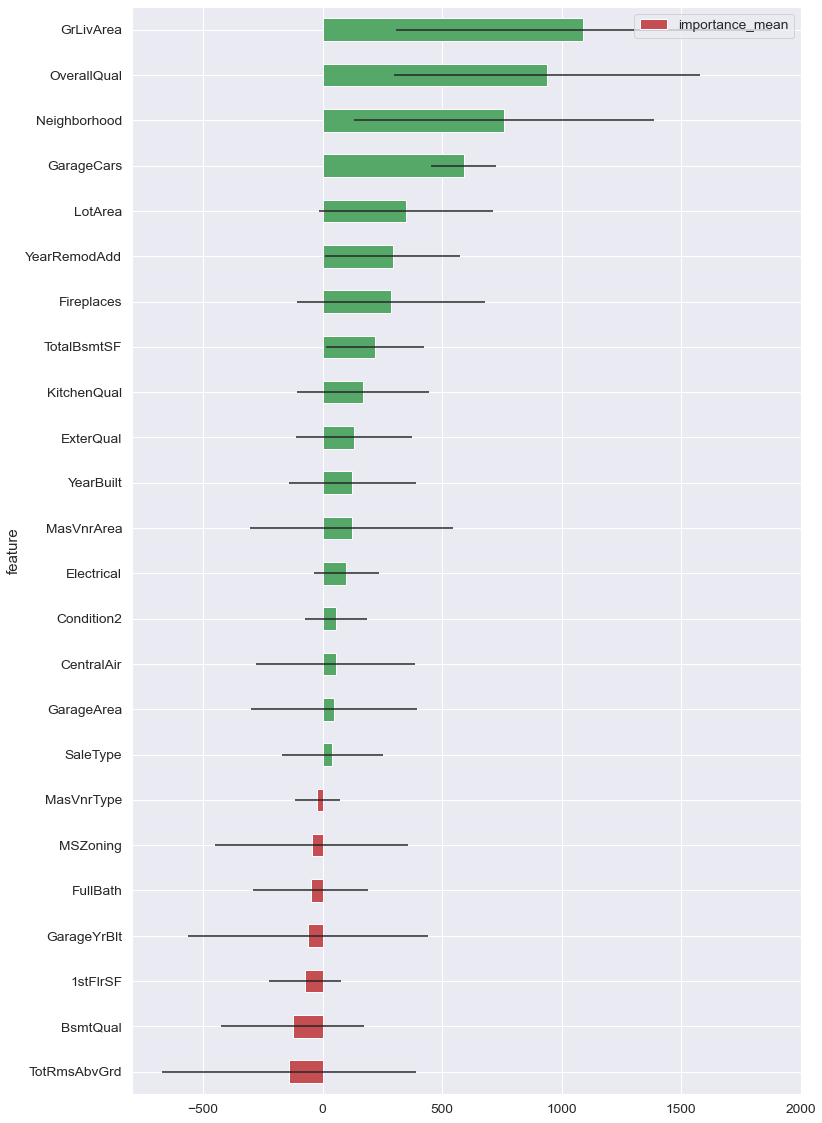

In [115]:
def feature_selection():
   
        
    df_train = pd.read_csv("HousePrices/train.csv")
    df_test = pd.read_csv("HousePrices/test.csv")
    
    df_train=df_train[['MSZoning', 'Neighborhood', 'Condition2', 'OverallQual', 'YearBuilt',
       'YearRemodAdd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'BsmtQual',
       'TotalBsmtSF', 'CentralAir', 'Electrical', '1stFlrSF', 'FullBath',
       'KitchenQual', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'SaleType', 'GrLivArea', 'LotArea','SalePrice']]

    dataset=Dataset(df=df_train,target="SalePrice", features=[col for col in df_train.columns if col != "SalePrice"])
    cv=KFold(n_splits=5, shuffle=True, random_state=10)
    lofo_imp = LOFOImportance(dataset, cv=cv, scoring="neg_mean_absolute_error")
    importance_df = lofo_imp.get_importance()
    plot_importance(importance_df, figsize=(12, 20))
    
feature_selection( )

In [116]:
def after_feature_selection():
    df_train,df_test,y,model_ridge,mae=train_data()   
    df_train=df_train[['Neighborhood', 'Condition2', 'OverallQual', 'YearBuilt','YearRemodAdd', 'MasVnrArea', 'ExterQual','TotalBsmtSF', 'CentralAir', 'Electrical', 
       'KitchenQual', 'Fireplaces', 'GarageCars', 'GarageArea', 'SaleType', 'GrLivArea_Log', 'LotArea_Log']]

    df_test=df_test[['Neighborhood', 'Condition2', 'OverallQual', 'YearBuilt','YearRemodAdd', 'MasVnrArea', 'ExterQual','TotalBsmtSF', 'CentralAir', 'Electrical', 
       'KitchenQual', 'Fireplaces', 'GarageCars', 'GarageArea', 'SaleType', 'GrLivArea_Log', 'LotArea_Log']]
    
    return df_train,df_test,y,model_ridge
    

In [117]:
def grid_or_random_search(search):
    
    
    df_train,df_test,y,model_ridge=after_feature_selection()
    folds  = KFold(n_splits=5,shuffle=True,random_state=42)

    hyper_param = {'alpha':[0.001,0.01,0.1,0.2,0.5,0.9,1.0, 5.0, 10.0,20.0],
              'tol':[1e-06,5e-06,1e-05,5e-05]}

    model = Ridge()
    df_train,df_test,y,model_ridge=after_feature_selection()
    
    if search=="grid":
        model_cv = GridSearchCV(estimator=model,
                            param_grid=hyper_param,
                            scoring='r2',
                            cv=folds,
                            verbose=1,
                            return_train_score=True)

    elif search=="random":
        model_cv =RandomizedSearchCV(estimator=model,
                            param_distributions=hyper_param,
                            scoring='r2',
                            cv=folds,
                            verbose=1,
                            return_train_score=True)
    
    results=model_cv.fit(df_train,y)
    print('Best Score: %.3f' % results.best_score_)
    print('Config: %s' % results.best_params_)
    
    ypred=model_cv.predict(df_test)
    print('MAE: %.5f' % mean_absolute_error(y,ypred[:-1]))
    
    
    
    return results,results.best_params_

results,results.best_params_=grid_or_random_search(search="grid")  


Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best Score: 0.880
Config: {'alpha': 1.0, 'tol': 1e-06}
MAE: 0.44264


Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


Fitting 5 folds for each of 1 candidates, totalling 5 fits
MAE: 0.880
0.4427835714161203


Permutation explainer: 1460it [00:57, 21.65it/s]                                                                       


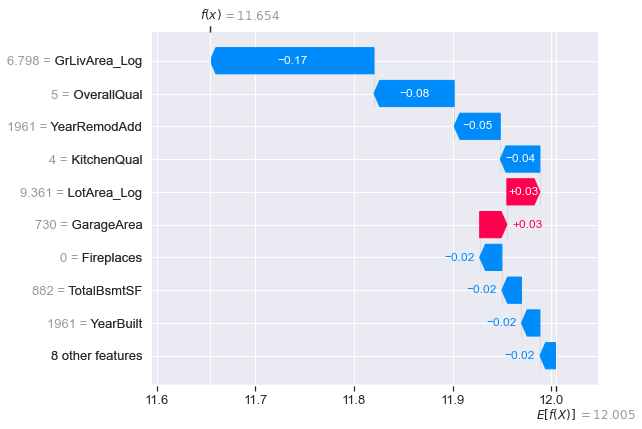

In [118]:
df_train,df_test,y,model_ridge=after_feature_selection()
# 'normalize': [True]
model = Ridge()
params={'alpha': [0.01], 'tol':[1e-06] }
folds  = KFold(n_splits=5,shuffle=True,random_state=42)
model_cv = GridSearchCV(estimator=model,
                            param_grid=params,
                            scoring='r2',
                            cv=folds,
                            verbose=1,
                            return_train_score=True)

results=model_cv.fit(df_train,y)
print('MAE: %.3f' % results.best_score_)

ypred=model_cv.predict(df_test)
print(mean_absolute_error(y,ypred[:-1]))

explainer = shap.Explainer(model_cv.predict,df_test)
shap_values = explainer(df_test)
shap.plots.waterfall(shap_values[0])

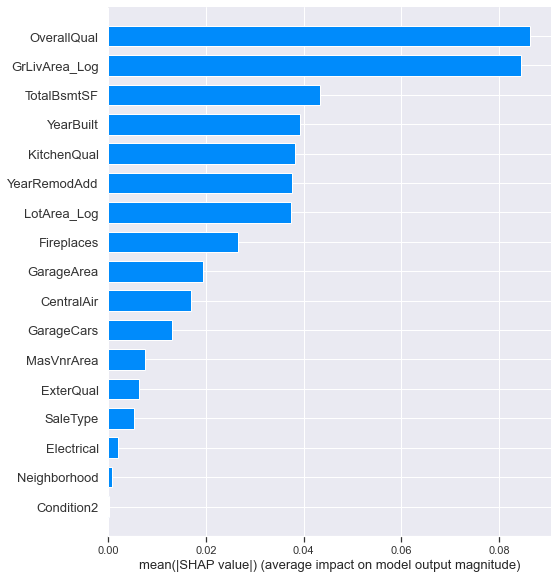

In [119]:
shap.summary_plot(shap_values,df_train, plot_type='bar')

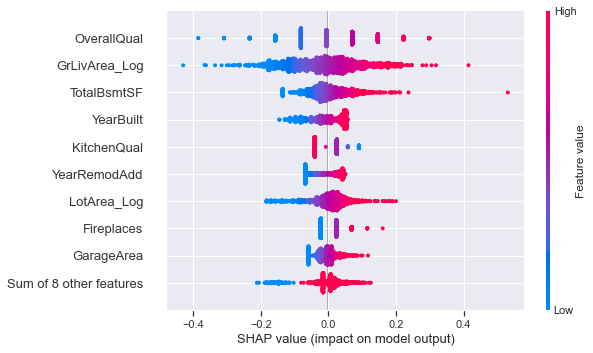

In [124]:
shap.plots.beeswarm(shap_values)


Each point on the chart is one SHAP value for a prediction and feature. Red color means higher value of a feature. Blue means lower value of a feature